### Imports

In [9]:
from re import A
import matplotlib.image as mpimg
from PIL import Image
from src.helpers.handling_images import img_crop, extract_data, extract_labels, label_to_img, make_img_overlay, concatenate_images, img_float_to_uint8
from src.helpers.helpers import error_rate
from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers

### Defining paths

In [3]:
train_data = 'data/training/images/'
train_labels= 'data/training/groundtruth/' 
testing_dir = 'data/testing/' #path for test images
test_images = 'predictions/testing/' #path to save test predictions

### Extracting data

In [5]:
train_data = extract_data(train_data)
train_labels = extract_labels(train_labels)

In [14]:
np.random.seed(1)

X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2)

In [15]:
# Balances the trainingset

c0 = 0  # bgrd
c1 = 0  # road
for i in range(len(X_train)):
    if y_train[i][0] == 1:
        c0 = c0 + 1
    else:
        c1 = c1 + 1
print('Number of data points per class: c0 = ' + str(c0) + ' c1 = ' + str(c1))

print('Balancing training data...')
min_c = min(c0, c1)
idx0 = [i for i, j in enumerate(y_train) if j[0] == 1]
idx1 = [i for i, j in enumerate(y_train) if j[1] == 1]
new_indices = idx0[0:min_c] + idx1[0:min_c]
print(len(new_indices))
print(X_train.shape)
X_train = X_train[new_indices, :, :, :]
y_train = y_train[new_indices]

train_size = y_train.shape[0]

c0 = 0
c1 = 0
for i in range(len(y_train)):
    if y_train[i][0] == 1:
        c0 = c0 + 1
    else:
        c1 = c1 + 1
print('Number of data points per class: c0 = ' + str(c0) + ' c1 = ' + str(c1))

Number of data points per class: c0 = 652716 c1 = 197284
Balancing training data...
394568
(850000, 16, 16, 3)
Number of data points per class: c0 = 197284 c1 = 197284


### Defining hyperparameters

In [25]:
epochs = 1
print(X_train.shape)
in_shape = X_train.shape[1:]


(394568, 16, 16, 3)


### Model

In [53]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(16,16,3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 14, 14, 32)        896       
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 2, 2, 128)         73856     
Total params: 130,176
Trainable params: 130,176
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 14, 14, 32)        896       
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 2, 2, 128)         73856     
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)             

In [55]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_test, y_test))
        

Epoch 1/20
12331/12331 [==============================] - 184s 15ms/step - loss: 0.5830 - accuracy: 0.6845 - val_loss: 0.4696 - val_accuracy: 0.7783
Epoch 2/20
12331/12331 [==============================] - 204s 17ms/step - loss: 0.5179 - accuracy: 0.7422 - val_loss: 0.4843 - val_accuracy: 0.7479
Epoch 3/20
12331/12331 [==============================] - 220s 18ms/step - loss: 0.5027 - accuracy: 0.7528 - val_loss: 0.4836 - val_accuracy: 0.7574
Epoch 4/20
12331/12331 [==============================] - 226s 18ms/step - loss: 0.4948 - accuracy: 0.7585 - val_loss: 0.5085 - val_accuracy: 0.7316
Epoch 5/20
 1405/12331 [==>...........................] - ETA: 2:36 - loss: 0.4886 - accuracy: 0.7613

In [50]:
model.save('benjamin_cnn')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: benjamin_cnn\assets


6641/6641 - 20s - loss: 0.7888 - accuracy: 0.4948


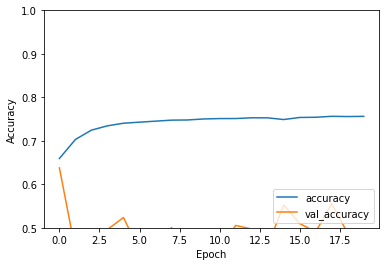

In [52]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)